This notebook creates a neuronal network with fully connected, pooling and convolutional layers to classify MNIST images

This model tries to improve accuracy score of our baseline estimator

## Import statements

In [1]:
import keras.backend as K
from keras.datasets import mnist
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from keras.models import Model
from keras.layers import Conv2D, AvgPool2D, Flatten, Activation, Input, Dense, MaxPool2D
from keras.optimizers import RMSprop
from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K

from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.metrics import confusion_matrix

%matplotlib inline

Using TensorFlow backend.


## Load dataset

In [2]:
data = np.load('./data/preprocessed.npz')
X, y  = data['X'], data['y']
y_cat = to_categorical(y)

X = X.reshape((-1, 28, 28, 1))

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True, random_state=13)
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

## Create the model

In [4]:
t_in = Input(shape=(28, 28, 1))
t_conv = Conv2D(filters=32, kernel_size=(3,3))(t_in)
t_pool = MaxPool2D(pool_size=(2, 2))(t_conv)
t_activation = Activation('relu')(t_pool)
t_flat = Flatten()(t_activation)

# Full connected layers part
t = Dense(units=32, activation='relu', use_bias=True)(t_flat)
t_out = Dense(units=10, activation='softmax', use_bias=True)(t)

model = Model(inputs=[t_in], outputs=[t_out])
model.compile(RMSprop(lr=.01), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()
initial_weights = model.get_weights()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
activation_1 (Activation)    (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 5408)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                173088    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                330       
Total para

## Cross-validate the model

In [26]:
def build():
    model.set_weights(initial_weights)
    return model
wrapper = KerasClassifier(build, batch_size=128, epochs=1, verbose=True)
cv = StratifiedKFold(3, shuffle=True, random_state=13)
cv_results = cross_val_score(wrapper, X_train, y_train, scoring='accuracy', cv=cv)
print('Done')

Epoch 1/1
21002/21002 [==============================] - 7s 334us/step
Epoch 1/1
21000/21000 [==============================] - 7s 313us/step
Epoch 1/1
20998/20998 [==============================] - 7s 317us/step
Done


In [29]:
cv_results

array([0.96828873, 0.92033333, 0.97137823])

In [30]:
print('Accuracy score is {} +- {}'.format(np.mean(cv_results), np.std(cv_results)))

Accuracy score is 0.9533334314124474 +- 0.023368655577778293


## Final prediction on test set

In [5]:
model.set_weights(initial_weights)
history = model.fit(X_train, y_train_cat, batch_size=128, epochs=2, verbose=True)

Epoch 1/2
63000/63000 [==============================] - 38s 599us/step - loss: 0.2414 - acc: 0.9339
Epoch 2/2
63000/63000 [==============================] - 37s 582us/step - loss: 0.1200 - acc: 0.9731


In [6]:
print('Accuracy on train set: {}'.format(model.evaluate(X_train, y_train_cat)[1].round(3)))
print('Accuracy on test set: {}'.format(model.evaluate(X_test, y_test_cat)[1].round(3)))

63000/63000 [==============================] - 28s 439us/step
Accuracy on train set: 0.978
7000/7000 [==============================] - 3s 439us/step
Accuracy on test set: 0.971


In [7]:
y_train_pred = np.argmax(model.predict(X_train), axis=1)
y_test_pred = np.argmax(model.predict(X_test), axis=1)

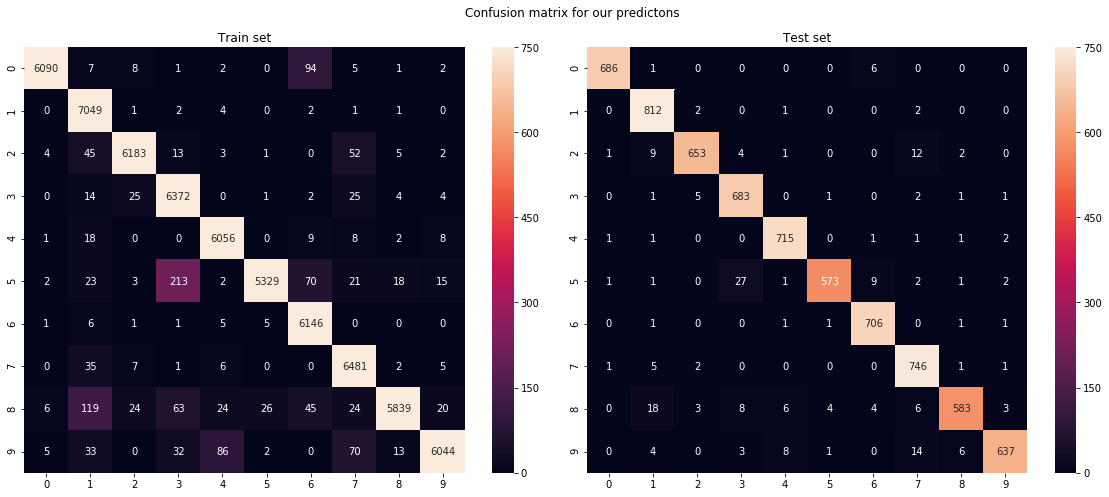

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(16, 7))

plt.sca(ax[0])
sns.heatmap(pd.DataFrame(confusion_matrix(y_train, y_train_pred)), annot=True, fmt='d', vmax=750)
plt.title('Train set')

plt.sca(ax[1])
sns.heatmap(pd.DataFrame(confusion_matrix(y_test, y_test_pred)), annot=True, fmt='d', vmax=750)
plt.title('Test set')

plt.suptitle('Confusion matrix for our predictons')
plt.tight_layout()
plt.subplots_adjust(top=0.9)

## Visualize the inner layers representation

In [39]:
x = X[4:5, :, :, :]

f_conv = K.Function([t_in], [t_conv])
y_conv = f_conv([ x ])[0]

f_pool = K.Function([t_conv], [t_pool])
y_pool = f_pool([ y_conv ])[0]

f_activation = K.Function([t_pool], [t_activation])
y_activation = f_activation([ y_pool ])[0]

In [40]:
print(x.shape)
print(y_conv.shape)
print(y_pool.shape)
print(y_activation.shape)

(1, 28, 28, 1)
(1, 26, 26, 32)
(1, 13, 13, 32)
(1, 13, 13, 32)


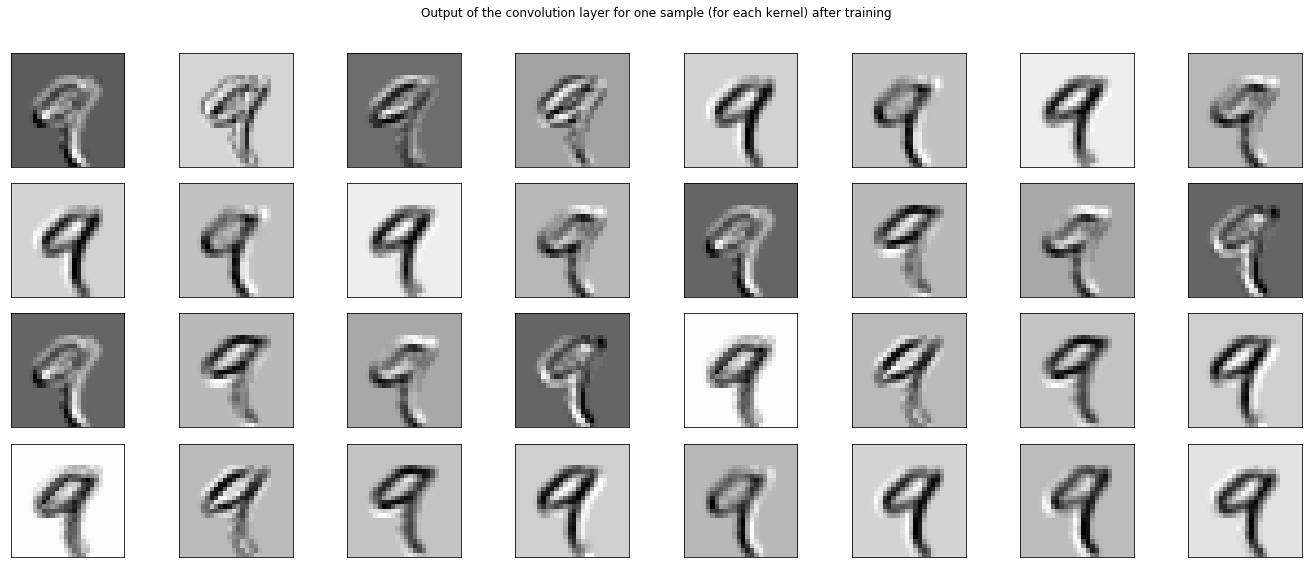

In [35]:
fig, ax = plt.subplots(4, 8, figsize=(19, 8))

for i in range(0, 4):
    for j in range(0, 8):
        plt.sca(ax[i, j])
        plt.imshow(y_conv[0, :, :, i * 4 + j], cmap='gray')
        plt.xticks([])
        plt.yticks([])

plt.suptitle('Output of the convolution layer for one sample (for each kernel) after training')
plt.tight_layout()
plt.subplots_adjust(top=0.9)

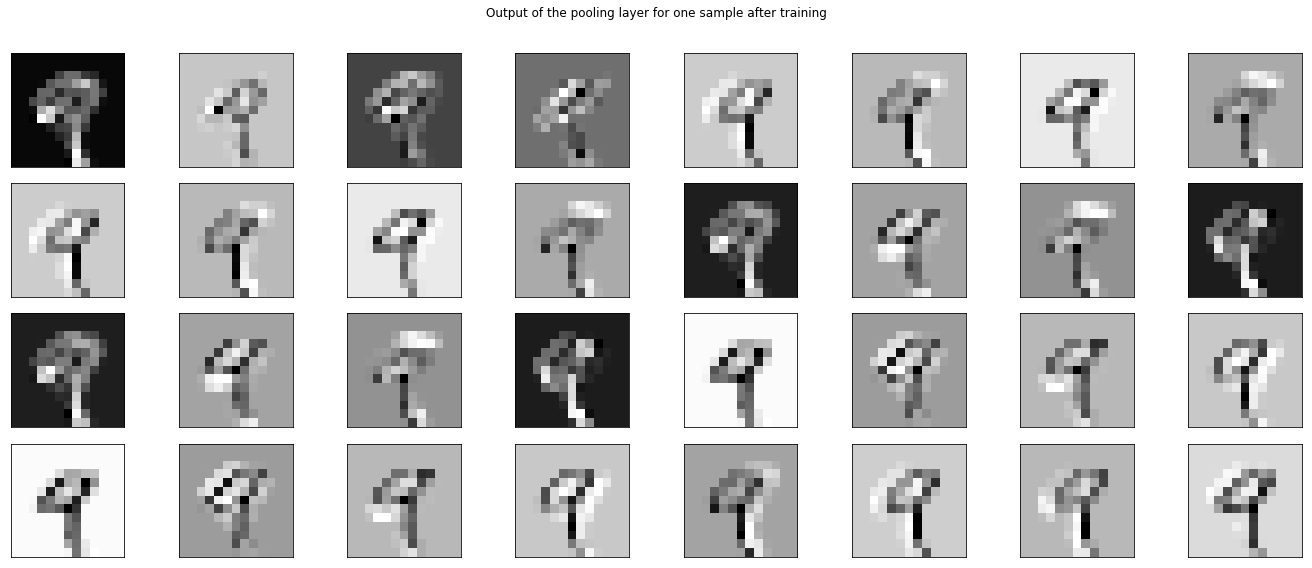

In [38]:
fig, ax = plt.subplots(4, 8, figsize=(19, 8))

for i in range(0, 4):
    for j in range(0, 8):
        plt.sca(ax[i, j])
        plt.imshow(y_pool[0, :, :, i * 4 + j], cmap='gray')
        plt.xticks([])
        plt.yticks([])

plt.suptitle('Output of the pooling layer for one sample after training')
plt.tight_layout()
plt.subplots_adjust(top=0.9)

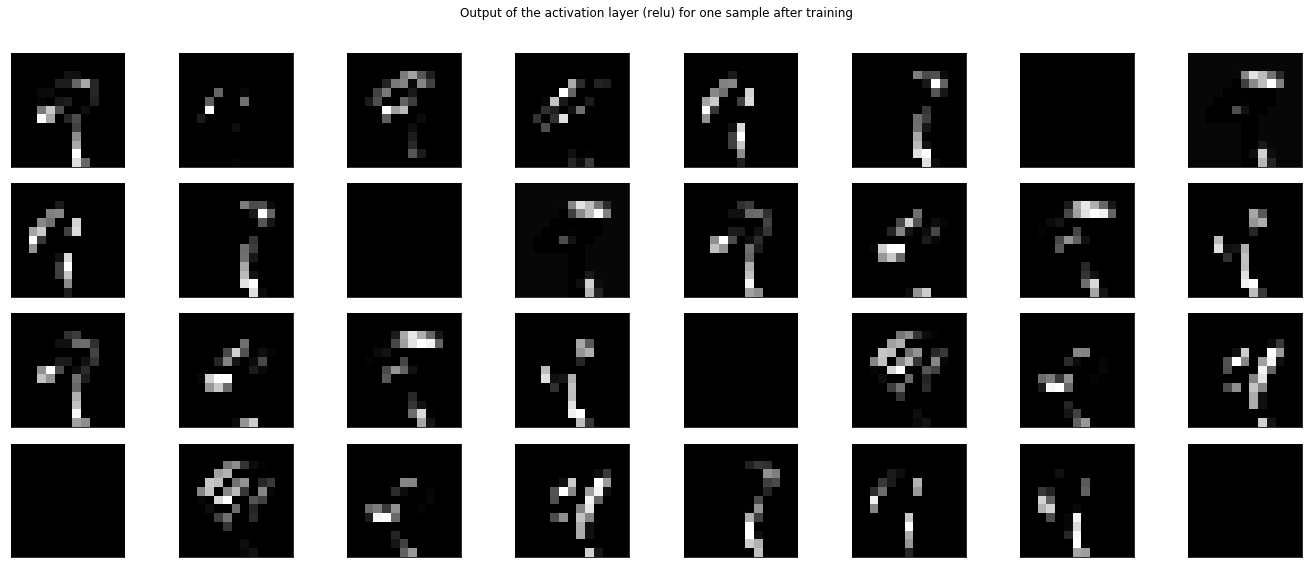

In [41]:
fig, ax = plt.subplots(4, 8, figsize=(19, 8))

for i in range(0, 4):
    for j in range(0, 8):
        plt.sca(ax[i, j])
        plt.imshow(y_activation[0, :, :, i * 4 + j], cmap='gray')
        plt.xticks([])
        plt.yticks([])

plt.suptitle('Output of the activation layer (relu) for one sample after training')
plt.tight_layout()
plt.subplots_adjust(top=0.9)